# Toy: AR1 model

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb](https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb) in the `sbi` repository.

## Main syntax

```Python
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)
```

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

seed = 0
torch.manual_seed(seed)

Next, we define the prior and simulator:

In [2]:
num_dim = 2
prior = utils.BoxUniform(low=[4.2,0.005], high=[5.8,0.025])

In [3]:
def generate_ar1_time_series(theta):
    time_series = np.zeros(length)
    time_series[0] = x_0
    for t in range(1, length):
        noise = np.random.normal(0, theta[1])
        time_series[t] =  theta[0] * time_series[t - 1]**2 * (1-time_series[t - 1]) + noise
    return time_series

In the flexible interface, you have to ensure that your simulator and prior adhere the requirements of `sbi`. You can do so with the `prepare_for_sbi()` function.

In [4]:
length = 200
x_0 = 0.25
simulator, prior = prepare_for_sbi(generate_ar1_time_series, prior)

In [6]:
input_size = 200
num_classes = 3

class SummaryNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1D convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        # Maxpool layer
        self.pool = nn.MaxPool1d(kernel_size=10, stride = 10)
        # Fully connected layer
        self.fc = nn.Linear(in_features=6 * (input_size // 10), out_features=num_classes)

    def forward(self, x):
        # Assuming x is of shape (batch_size, 1, input_size)
        x =x.view(-1,1,200)
        x = self.conv1(x)
        x = self.pool(x)
        # Flatten the output before passing it to the fully connected layer
        x = x.view(-1,6*20)
        x = self.fc(x)
        return x

embedding_net = SummaryNet()


In [6]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

Then, we instantiate the inference object:

Next, we run simulations. You can do so either by yourself by sampling from the prior and running the simulator (e.g. on a compute cluster), or you can use a helper function provided by `sbi` called `simulate_for_sbi`. This function allows to parallelize your code with `joblib`.

In [7]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

We then pass the simulated data to the inference object. `theta` and `x` should both be a `torch.Tensor` of type `float32`.

In [8]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 421 epochs.

Lastly, we can use this density estimator to build the posterior:

In [9]:
posterior = inference.build_posterior(density_estimator)

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.

In [10]:
# Example usage:
c = 5.3
noise_std = 0.015  # Standard deviation of the additive noise

x_o = generate_ar1_time_series([c, noise_std])

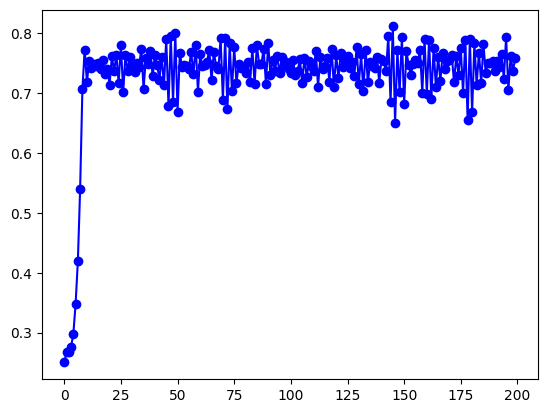

In [35]:
plt.plot(x_o, label='Time Series Data', color='blue', marker='o', linestyle='-')

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

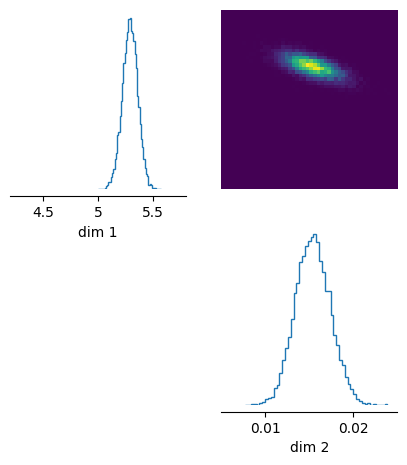

In [36]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

We can always print the posterior to know how it was trained:

In [51]:
print(posterior)

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [44]:
proposal = posterior.set_default_x(x_o)

In [45]:
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [46]:
density_estimator = inference.append_simulations(
        theta, x, proposal=proposal).train()

Using SNPE-C with atomic loss
 Neural network successfully converged after 97 epochs.

In [47]:
posterior = inference.build_posterior(density_estimator)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

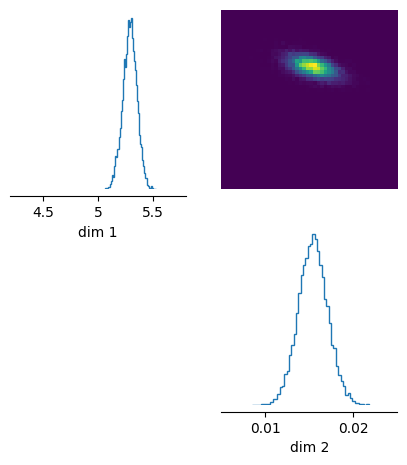

In [48]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

In [50]:
AR1PostSample = posterior.sample((1000,), x=x_o)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
AR1PostSampleArray = AR1PostSample.numpy()

In [52]:
np.savetxt("test.txt", AR1PostSampleArray, delimiter=',')

In [1]:
import julia 

In [2]:
from julia.api import Julia

In [6]:
jpath = "/Applications/Julia-1.9.app/Contents/Resources/julia/bin/julia" # path to Julia, from current directory (your path may be slightly different)
jl = Julia(runtime=jpath, compiled_modules=False) # compiled_modules=True may work for you; it didn't for me


In [7]:
from julia import Main